0. Описать задачу словами
1. Прочитать данные + 
2. Визуализировать данные и вычислить основные характеристики (среднее, разброс, корреляционную матрицу и т.д.). Интерпретировать. +
3. Обработать пропущенные значения (или убедиться, что их нет) +
4. Обработать категориальные признаки +
5. Провести нормализацию (или объяснить, почему в вашем случае она не нужна) +
6. Разбить данные на обучающую и тестовую выборки +
7. Запустить классификатор ближайших соседей (попробовать разное их количество) +
8. Вычислить ошибки на обучающей и тестовой выборках. Сделать выводы  +
9. По желанию: запустить другие классификаторы. Сравнить результаты +
10. По желанию: как-то побороться с несбалансированностью классов (если она есть)
11. По желанию: исключить коррелированные переменные (объяснить зачем)
12. Сделать общие выводы

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split, StratifiedKFold, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, f1_score, recall_score

plt.style.use('seaborn')

# Загрузка данных

In [2]:
raw_data = pd.read_csv("data/income_evaluation.csv", skipinitialspace=True)

In [3]:
raw_data.shape

(32561, 15)

In [4]:
raw_data.dtypes

age                int64
workclass         object
fnlwgt             int64
education         object
education-num      int64
marital-status    object
occupation        object
relationship      object
race              object
sex               object
capital-gain       int64
capital-loss       int64
hours-per-week     int64
native-country    object
income            object
dtype: object

Смотрим размерность и типы данных. В датасете приобладают категоральные признаки.

In [5]:
raw_data.drop("education", axis=1, inplace=True)

Можно сразу убрать данный признак так как он дублирует признак education-num который подходит больше.

In [6]:
raw_data.head(10)

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


In [7]:
raw_data.describe(include='all')

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
count,32561.000000,32561,3.256100e+04,32561.000000,32561,32561,32561,32561,32561,32561.000000,32561.000000,32561.000000,32561,32561
unique,NaN,9,NaN,NaN,7,15,6,5,2,NaN,NaN,NaN,42,2
top,NaN,Private,NaN,NaN,Married-civ-spouse,Prof-specialty,Husband,White,Male,NaN,NaN,NaN,United-States,<=50K
freq,NaN,22696,NaN,NaN,14976,4140,13193,27816,21790,NaN,NaN,NaN,29170,24720
mean,38.581647,NaN,1.897784e+05,10.080679,NaN,NaN,NaN,NaN,NaN,1077.648844,87.303830,40.437456,NaN,NaN
std,13.640433,NaN,1.055500e+05,2.572720,NaN,NaN,NaN,NaN,NaN,7385.292085,402.960219,12.347429,NaN,NaN
min,17.000000,NaN,1.228500e+04,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,1.000000,NaN,NaN
25%,28.000000,NaN,1.178270e+05,9.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
50%,37.000000,NaN,1.783560e+05,10.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,40.000000,NaN,NaN
75%,48.000000,NaN,2.370510e+05,12.000000,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,45.000000,NaN,NaN


In [8]:
raw_data[raw_data["capital-gain"] == 99999]

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
1246,54,Self-emp-inc,166459,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,60,United-States,>50K
1368,52,Private,152234,9,Married-civ-spouse,Exec-managerial,Husband,Asian-Pac-Islander,Male,99999,0,40,Japan,>50K
1482,53,Self-emp-inc,263925,9,Married-civ-spouse,Sales,Husband,White,Male,99999,0,40,United-States,>50K
1528,52,Private,118025,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,50,United-States,>50K
1616,46,Private,370119,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,99999,0,60,United-States,>50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31828,47,Private,155664,14,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,United-States,>50K
31972,43,Self-emp-inc,62026,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K
32090,66,Private,115498,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,55,?,>50K
32238,47,Private,294913,15,Married-civ-spouse,Exec-managerial,Husband,White,Male,99999,0,40,United-States,>50K


In [9]:
raw_data[raw_data["hours-per-week"] == 99]

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
935,37,Private,176900,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,99,United-States,>50K
1172,25,Private,404616,14,Married-civ-spouse,Farming-fishing,Not-in-family,White,Male,0,0,99,United-States,>50K
1887,55,Self-emp-not-inc,184425,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,99,United-States,>50K
3578,37,Self-emp-inc,382802,16,Married-civ-spouse,Prof-specialty,Husband,Black,Male,0,0,99,United-States,>50K
4086,50,?,174964,6,Married-civ-spouse,?,Husband,White,Male,0,0,99,United-States,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30992,40,Self-emp-inc,104235,14,Never-married,Other-service,Own-child,White,Male,0,0,99,United-States,<=50K
31681,43,Private,266324,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,1902,99,United-States,>50K
31699,43,Self-emp-not-inc,163108,10,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,99,United-States,<=50K
32469,58,Self-emp-inc,181974,16,Never-married,Prof-specialty,Not-in-family,White,Female,0,0,99,?,<=50K


In [10]:
raw_data.isna().sum()

age               0
workclass         0
fnlwgt            0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [11]:
categorical = [col for col in raw_data.columns if raw_data[col].dtype=='O']
noncategorical = [col for col in raw_data.columns if raw_data[col].dtype != 'O']
for col in categorical:
    print(col, raw_data[col].nunique())

workclass 9
marital-status 7
occupation 15
relationship 6
race 5
sex 2
native-country 42
income 2


In [12]:
for col in categorical:
    print(raw_data[col].value_counts())

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64
Husband           13193
Not-in-family      8305
Own-child      

In [13]:
binary = [col for col in raw_data.columns if raw_data[col].nunique() == 2]
print(binary)

['sex', 'income']


In [14]:
raw_data.replace({'workclass': {'?':"Private"}, 'occupation': {'?':"Other-service"}, 'native-country': {'?':"United-States"}}, inplace=True)

In [15]:
for col in categorical:
    print(raw_data[col].value_counts())

Private             24532
Self-emp-not-inc     2541
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64
Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64
Other-service        5138
Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Machine-op-inspct    2002
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64
Husband           13193
Not-in-family      8305
Own-child          5068
Unmarried          3446
Wife               

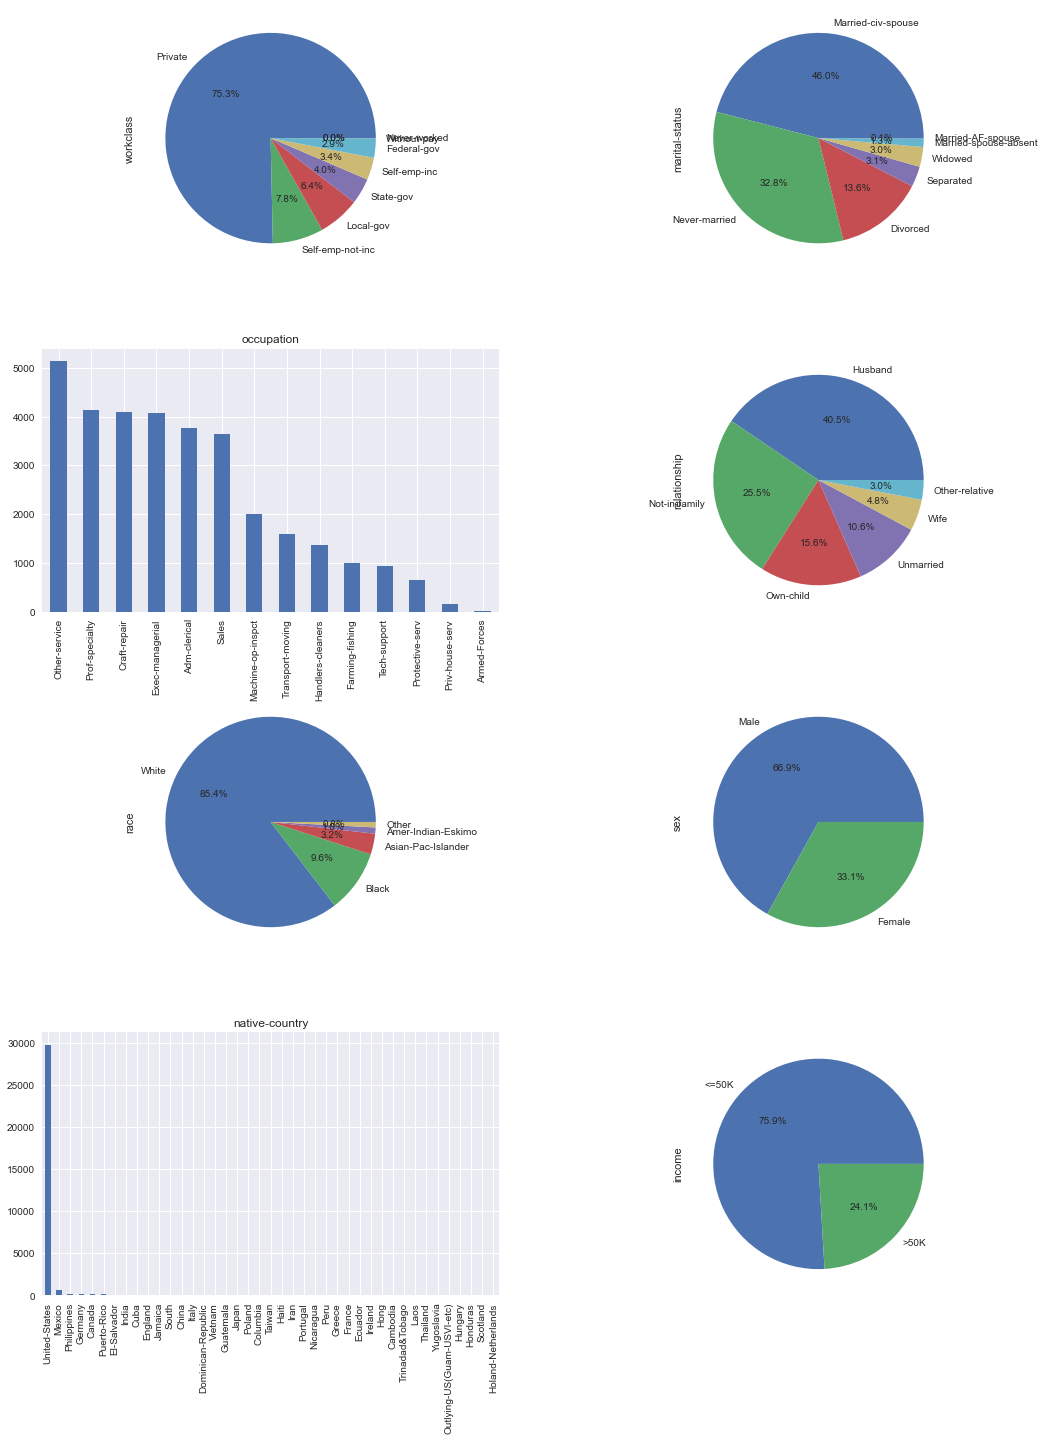

In [16]:
fig = plt.figure(figsize=(18,30))
fig.subplots_adjust(hspace=0.3)

for i in range(len(categorical)):
    ax = fig.add_subplot(5, 2, i+1)
    if(raw_data[categorical[i]].nunique() <= 8):
        ax = raw_data[categorical[i]].value_counts().plot(kind='pie', autopct='%1.1f%%')
    else:
        ax = raw_data[categorical[i]].value_counts().plot(kind='bar')
        ax.set_title(categorical[i])



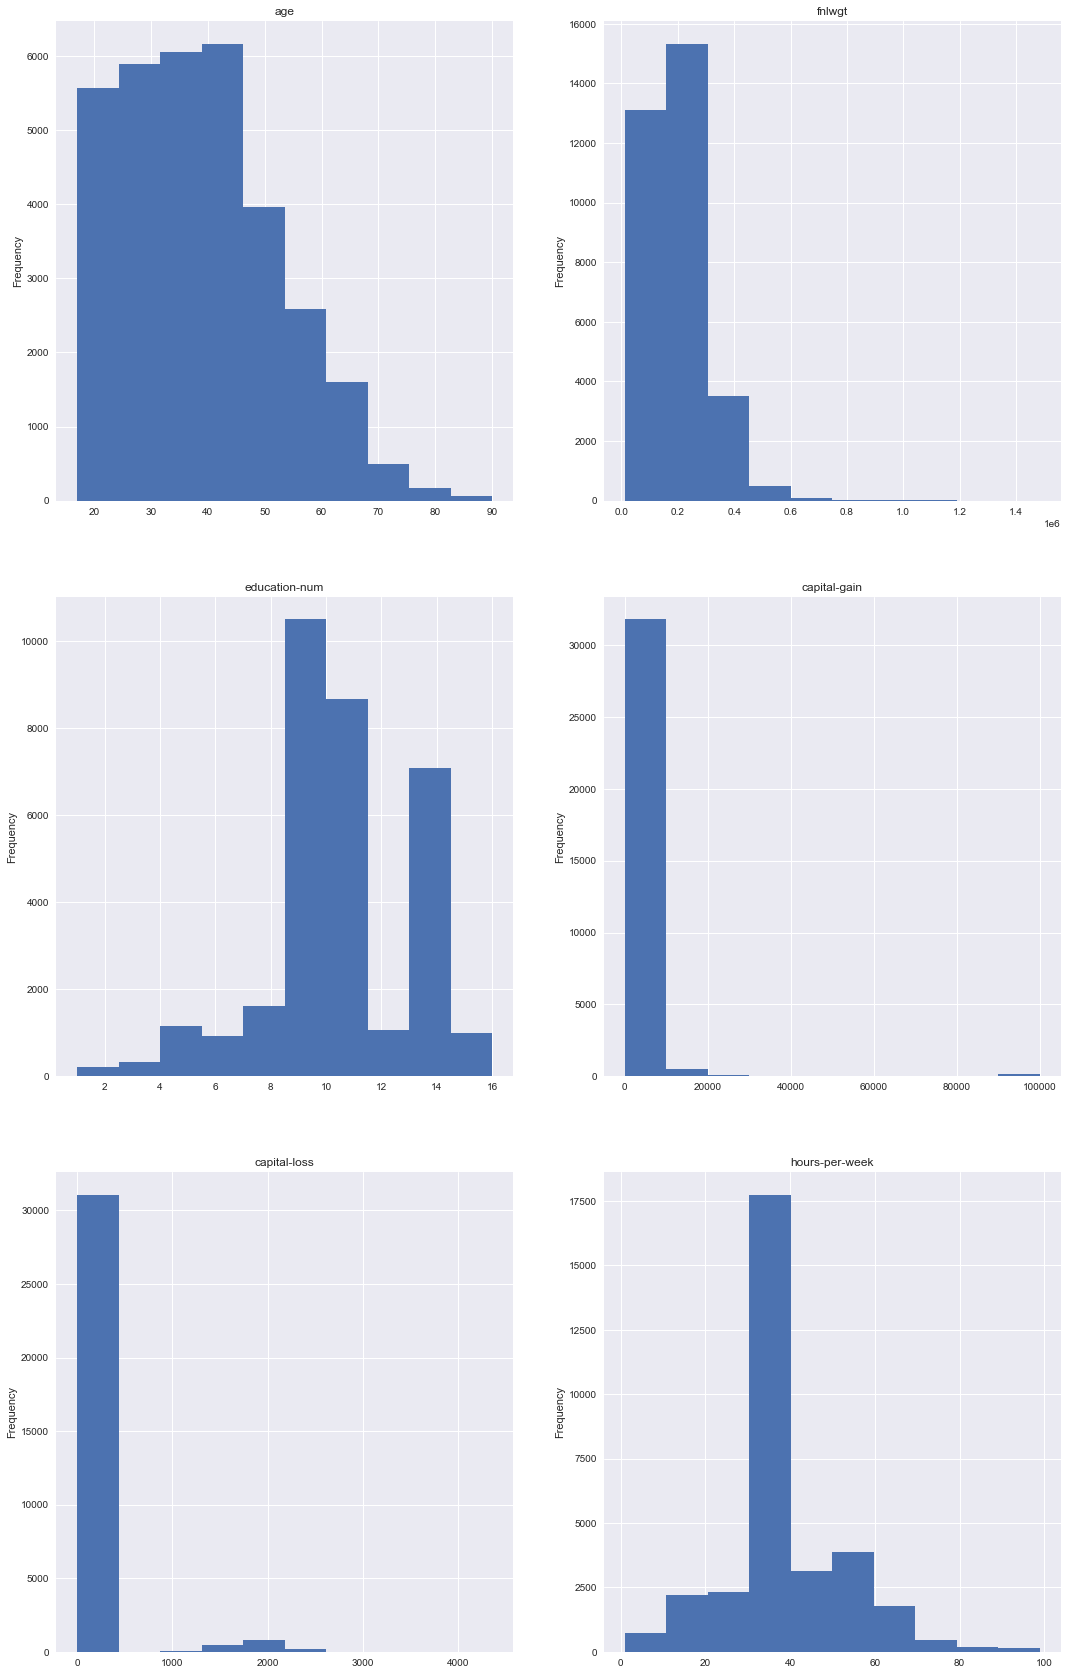

In [17]:
fig = plt.figure(figsize=(18,30))

for i in range(len(noncategorical)):
    ax = fig.add_subplot(3, 2, i+1)
    ax = raw_data[noncategorical[i]].plot(kind="hist")
    ax.set_title(noncategorical[i])

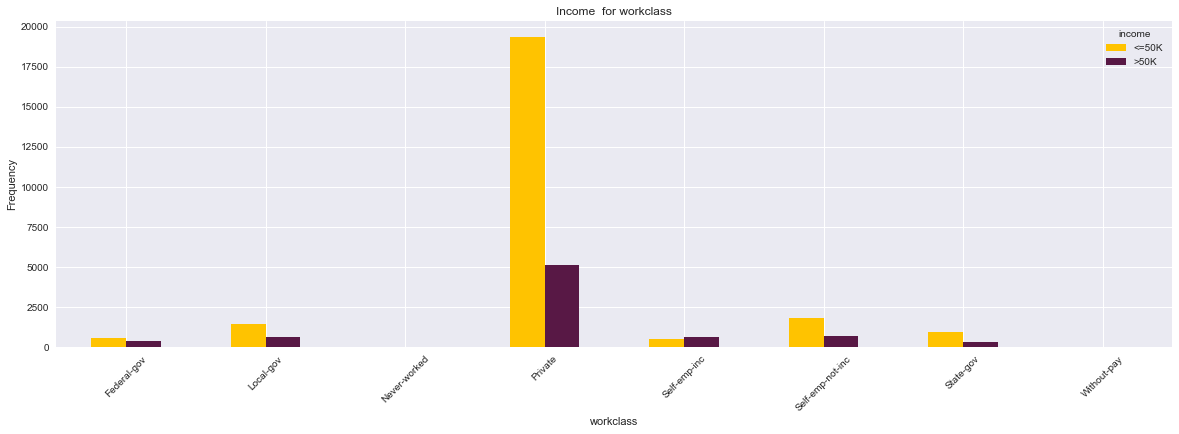

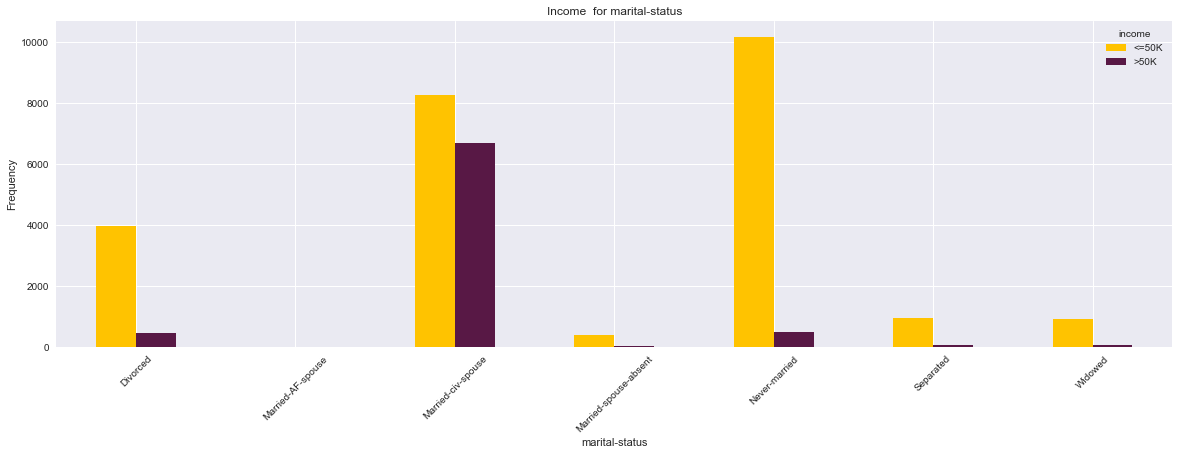

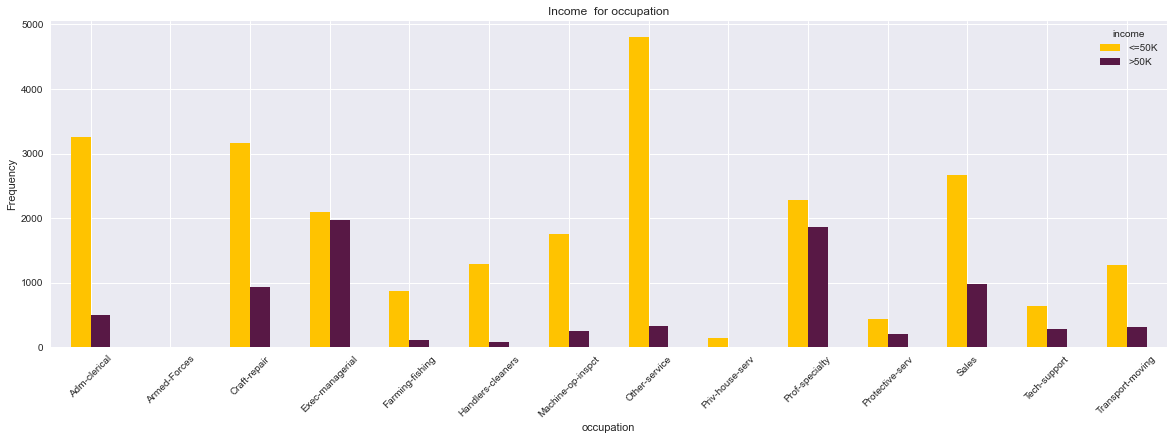

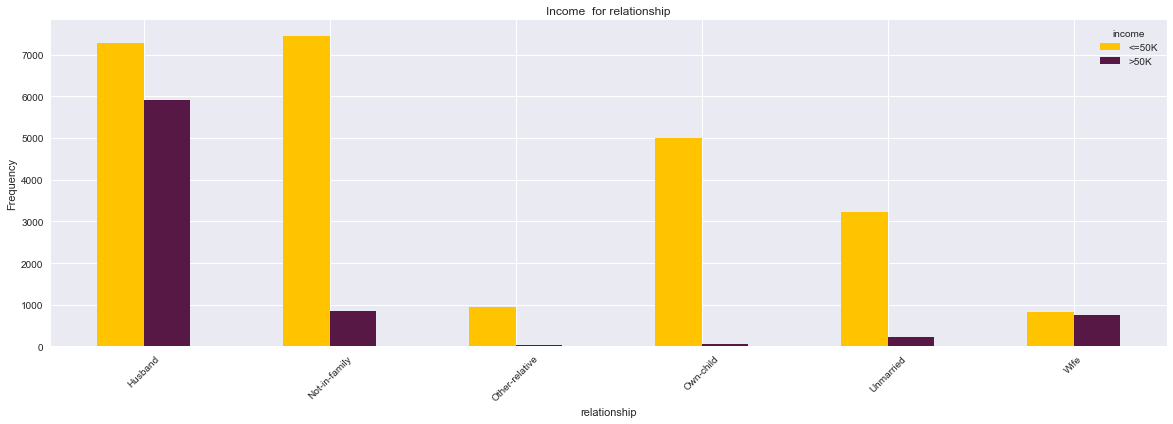

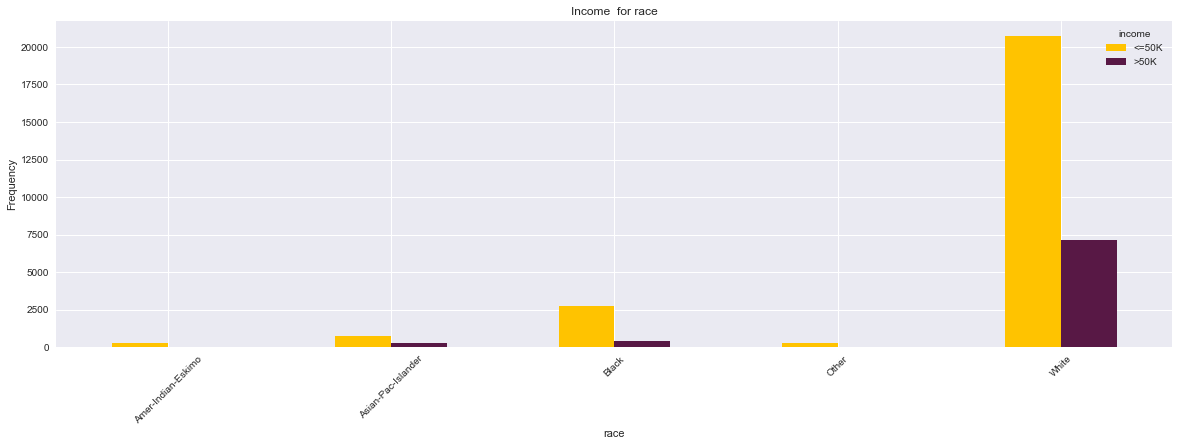

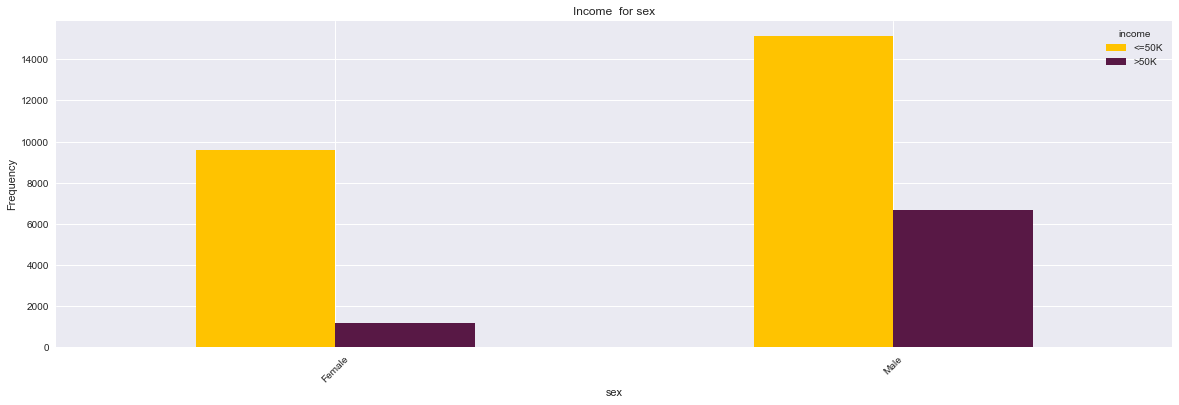

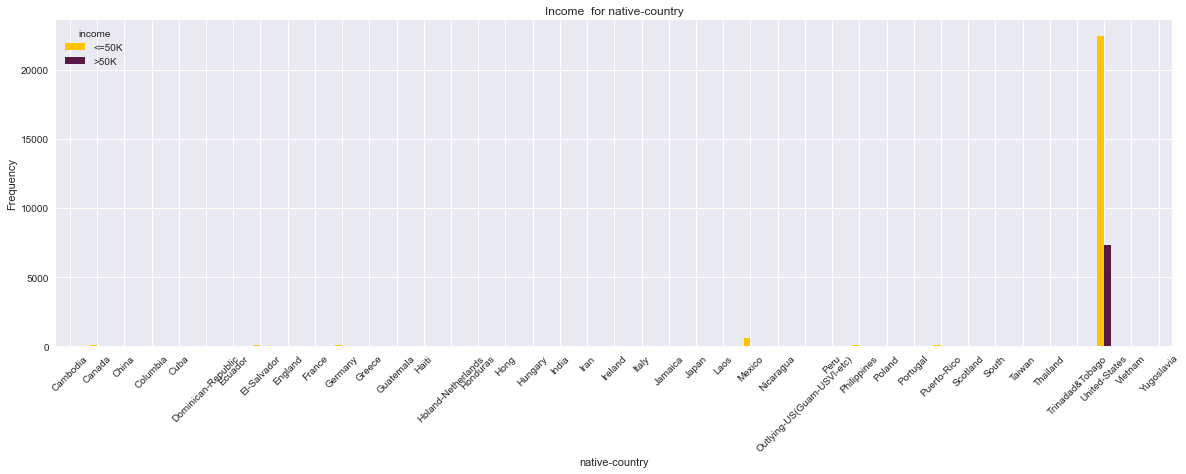

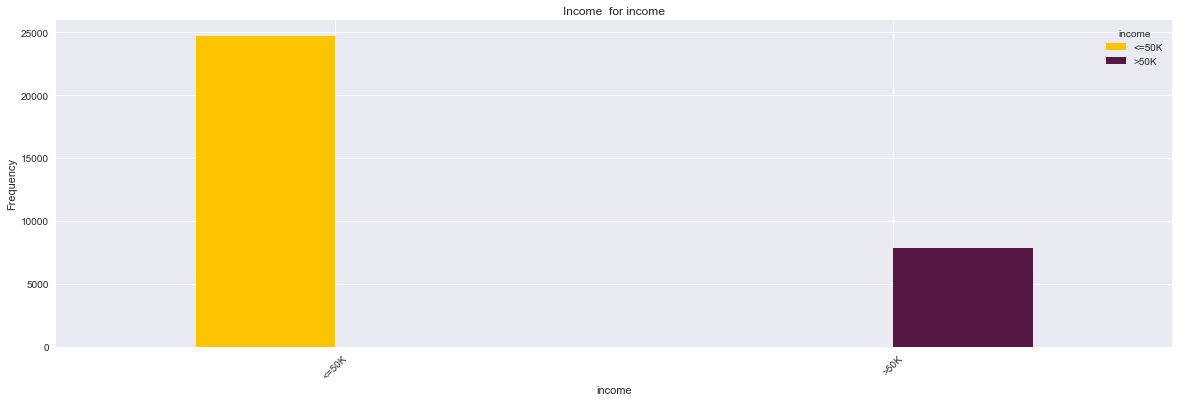

In [23]:
for col in categorical:
    pd.crosstab(raw_data[col], raw_data['income']).plot(kind="bar",figsize=(20,6),color=['#FFC300','#581845' ])
    plt.title('Income  for ' + col)
    plt.xticks(rotation=45)
    plt.ylabel('Frequency')
    plt.show()

In [18]:
raw_data.corr()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
age,1.000000,-0.076646,0.036527,0.077674,0.057775,0.068756
fnlwgt,-0.076646,1.000000,-0.043195,0.000432,-0.010252,-0.018768
education-num,0.036527,-0.043195,1.000000,0.122630,0.079923,0.148123
capital-gain,0.077674,0.000432,0.122630,1.000000,-0.031615,0.078409
capital-loss,0.057775,-0.010252,0.079923,-0.031615,1.000000,0.054256
hours-per-week,0.068756,-0.018768,0.148123,0.078409,0.054256,1.000000


In [25]:
final_data = raw_data.copy()

Обработаем категориальные значения и переведем их в числовые.

In [26]:
final_data[categorical] = final_data[categorical].apply(lambda col:pd.Categorical(col).codes)
final_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,77516,13,4,0,1,4,1,2174,0,40,38,0
1,50,5,83311,13,2,3,0,4,1,0,0,13,38,0
2,38,3,215646,9,0,5,1,4,1,0,0,40,38,0
3,53,3,234721,7,2,5,0,2,1,0,0,40,38,0
4,28,3,338409,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,3,257302,12,2,12,5,4,0,0,0,38,38,0
32557,40,3,154374,9,2,6,0,4,1,0,0,40,38,1
32558,58,3,151910,9,6,0,4,4,0,0,0,40,38,0
32559,22,3,201490,9,4,0,3,4,1,0,0,20,38,0


In [27]:
to_normalize = ["fnlwgt", "capital-gain","capital-loss", "hours-per-week"]

std_scaler = preprocessing.StandardScaler()

final_data[to_normalize] = std_scaler.fit_transform(final_data[to_normalize])
final_data

,age,workclass,fnlwgt,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,6,-1.063611,13,4,0,1,4,1,0.148453,-0.21666,-0.035429,38,0
1,50,5,-1.008707,13,2,3,0,4,1,-0.145920,-0.21666,-2.222153,38,0
2,38,3,0.245079,9,0,5,1,4,1,-0.145920,-0.21666,-0.035429,38,0
3,53,3,0.425801,7,2,5,0,2,1,-0.145920,-0.21666,-0.035429,38,0
4,28,3,1.408176,13,2,9,5,2,0,-0.145920,-0.21666,-0.035429,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,3,0.639741,12,2,12,5,4,0,-0.145920,-0.21666,-0.197409,38,0
32557,40,3,-0.335433,9,2,6,0,4,1,-0.145920,-0.21666,-0.035429,38,1
32558,58,3,-0.358777,9,6,0,4,4,0,-0.145920,-0.21666,-0.035429,38,0
32559,22,3,0.110960,9,4,0,3,4,1,-0.145920,-0.21666,-1.655225,38,0


Нормализуем количсетвенные признаки.

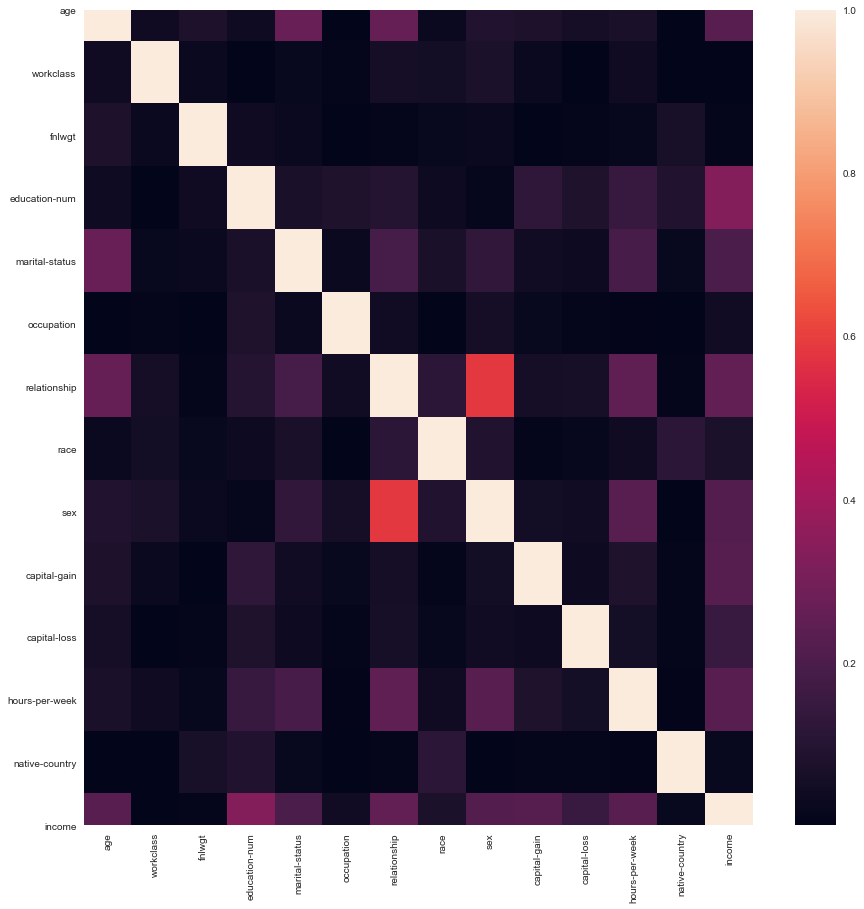

In [28]:
plt.figure(figsize=(15,15))
sns.heatmap(abs(final_data.corr()))

Из корреляционной матрицы видим, что наибольшее влияние на целевую пременную имеет уровень образования. Остальные признаки имеют коэфициент в районе 0.2-0.3

In [29]:
X = final_data.drop('income', axis = 1)
y = final_data['income']

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 2020)

Разделяем данные на тренировочные и тестовые в процпорции 4 к 1.

### KNN

In [31]:
nnb = [15, 16, 17, 18, 19, 20, 21, 22, 23]

knn = KNeighborsClassifier()
grid = GridSearchCV(knn, param_grid = {'n_neighbors': nnb}, cv=5)
grid.fit(X_train, y_train)

best_cv_err = grid.best_score_
best_n_neighbors = grid.best_estimator_.n_neighbors
print(best_cv_err, best_n_neighbors)

0.8214834152334153 15


Поиском гиперпараметров находим некоторое лучшее значение и получаем оценку в 0.82, что является довольно плохим качеством преждсказаний.

In [33]:
def check_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    
    y_test_predict = model.predict(X_test)
    y_train_predict = model.predict(X_train)
    print(confusion_matrix(y_test, y_test_predict))
    print(classification_report(y_test, y_test_predict))

    err_test  = np.mean(y_test  != y_test_predict)
    err_train = np.mean(y_train != y_train_predict)
    print(err_train, err_test)

In [34]:
knn = KNeighborsClassifier(n_neighbors = grid.best_estimator_.n_neighbors)

check_model(knn, X_train, X_test, y_train, y_test)

[[4572  370]
 [ 706  865]]
              precision    recall  f1-score   support

           0       0.87      0.93      0.89      4942
           1       0.70      0.55      0.62      1571

    accuracy                           0.83      6513
   macro avg       0.78      0.74      0.76      6513
weighted avg       0.83      0.83      0.83      6513

0.15463759213759215 0.1652080454475664


Проверим модель с полученным гиперпараметром на тестовой и обучающей выборках. Мы видим что модель ошиблась в 15.5% случаев на обучающей выборке и в 16.5% случаев на тестовой выборке

### Random Forest

In [44]:
rskf = RepeatedStratifiedKFold(n_splits=5, n_repeats=5)
rf_model = RandomForestClassifier()
params = {'n_estimators': range(20, 90, 10), 'max_depth': range(10,20,2), 'min_samples_split': [10]}
clf_rand = GridSearchCV(rf_model, params, cv=rskf, scoring='f1_micro', n_jobs=6)

In [45]:
%%time
clf_rand.fit(X_train, y_train)
pass

Wall time: 1min 34s


In [46]:
print(clf_rand.best_score_)
print(clf_rand.best_estimator_)

0.8639665233415234
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=16, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=70,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [47]:
rf_model = RandomForestClassifier(n_estimators=clf_rand.best_estimator_.n_estimators, 
                                  max_depth=clf_rand.best_estimator_.max_depth, 
                                  min_samples_split=clf_rand.best_estimator_.min_samples_split)
check_model(rf_model, X_train, X_test, y_train, y_test)

[[4690  252]
 [ 594  977]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4942
           1       0.79      0.62      0.70      1571

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.86      6513

0.09897113022113022 0.1298940580377706


In [48]:
pd.Series(rf_model.feature_importances_, 
          index=X_train.columns).sort_values(ascending=False)

capital-gain      0.173318
relationship      0.163274
education-num     0.156374
marital-status    0.120234
age               0.097621
hours-per-week    0.067137
fnlwgt            0.058510
capital-loss      0.054956
occupation        0.049211
workclass         0.024948
native-country    0.012546
sex               0.012458
race              0.009413
dtype: float64

### Decision Tree

In [49]:
params = {"max_depth": [None, 5, 7, 10, 15], "min_samples_leaf": [ 7, 10, 12, 15], "min_samples_split": [2, 5, 7, 10]}

dtree = DecisionTreeClassifier()
clf_dtree = GridSearchCV(dtree, params, cv=rskf, scoring='f1_micro', n_jobs=6)

In [50]:
%%time
clf_dtree.fit(X_train, y_train)
pass

Wall time: 19.1 s


In [51]:
print(clf_dtree.best_score_)
print(clf_dtree.best_estimator_)

0.8536547911547911
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [52]:
dtree = DecisionTreeClassifier(max_depth=clf_dtree.best_estimator_.max_depth,
                               min_samples_leaf=clf_dtree.best_estimator_.min_samples_leaf,
                               min_samples_split=clf_dtree.best_estimator_.min_samples_split)
check_model(dtree, X_train, X_test, y_train, y_test)

[[4701  241]
 [ 695  876]]
              precision    recall  f1-score   support

           0       0.87      0.95      0.91      4942
           1       0.78      0.56      0.65      1571

    accuracy                           0.86      6513
   macro avg       0.83      0.75      0.78      6513
weighted avg       0.85      0.86      0.85      6513

0.1423141891891892 0.1437125748502994


In [35]:
final_data_v2 = raw_data.copy()

In [36]:
final_data_v2[binary] = final_data_v2[binary].apply(lambda col:pd.Categorical(col).codes)

In [37]:
to_encode = [x for x in categorical if (x not in binary)]
to_encode

['workclass',
 'marital-status',
 'occupation',
 'relationship',
 'race',
 'native-country']

In [38]:
for col in to_encode:
    dummies = pd.get_dummies(final_data_v2[col], prefix=col)
    final_data_v2 = pd.concat((final_data_v2, dummies), axis=1)
    final_data_v2.drop([col], axis=1, inplace=True)

In [39]:
final_data_v2

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,77516,13,1,2174,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,83311,13,1,0,0,13,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,215646,9,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,234721,7,1,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,338409,13,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,257302,12,0,0,0,38,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,154374,9,1,0,0,40,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,151910,9,0,0,0,40,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,201490,9,1,0,0,20,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [40]:
final_data_v2[to_normalize] = std_scaler.fit_transform(final_data_v2[to_normalize])
final_data_v2

,age,fnlwgt,education-num,sex,capital-gain,capital-loss,hours-per-week,income,workclass_Federal-gov,workclass_Local-gov,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
0,39,-1.063611,13,1,0.148453,-0.21666,-0.035429,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,50,-1.008707,13,1,-0.145920,-0.21666,-2.222153,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,38,0.245079,9,1,-0.145920,-0.21666,-0.035429,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,53,0.425801,7,1,-0.145920,-0.21666,-0.035429,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,1.408176,13,0,-0.145920,-0.21666,-0.035429,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,0.639741,12,0,-0.145920,-0.21666,-0.197409,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32557,40,-0.335433,9,1,-0.145920,-0.21666,-0.035429,1,0,0,...,0,0,0,0,0,0,0,1,0,0
32558,58,-0.358777,9,0,-0.145920,-0.21666,-0.035429,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32559,22,0.110960,9,1,-0.145920,-0.21666,-1.655225,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [56]:
abs(final_data_v2.corr())["income"].sort_values(ascending=False)

income                               1.000000
marital-status_Married-civ-spouse    0.444696
relationship_Husband                 0.401035
education-num                        0.335154
marital-status_Never-married         0.318440
                                       ...   
native-country_Cuba                  0.002827
native-country_Greece                0.002448
native-country_Ireland               0.002063
native-country_Hungary               0.000469
native-country_Scotland              0.000413
Name: income, Length: 89, dtype: float64

In [57]:
X_v2 = final_data_v2.drop('income', axis = 1)
y_v2 = final_data_v2['income']
X_train, X_test, y_train, y_test = train_test_split(X_v2, y_v2, test_size = 0.2, random_state = 2020)

In [58]:
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [59]:
rf_model = RandomForestClassifier()
clf_rand = RandomizedSearchCV(rf_model, param_distributions = random_grid, cv = 3, verbose=2, n_iter = 100, n_jobs=5)

In [90]:
%%time
clf_rand.fit(X_train, y_train)
pass

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  31 tasks      | elapsed:  2.2min
[Parallel(n_jobs=5)]: Done 152 tasks      | elapsed: 12.1min
[Parallel(n_jobs=5)]: Done 300 out of 300 | elapsed: 24.8min finished


Wall time: 25min 27s


In [93]:
check_model(clf_rand.best_estimator_, X_train, X_test, y_train, y_test)

[[4684  258]
 [ 585  986]]
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      4942
           1       0.79      0.63      0.70      1571

    accuracy                           0.87      6513
   macro avg       0.84      0.79      0.81      6513
weighted avg       0.87      0.87      0.87      6513

0.07217444717444717 0.1294334408106863


## Вывод

Было рассмотрено 3 классификатора. Метод KNN справлялся несколько хуже чем Random Forest или Decision Tree.  
Доля ошибок для тестовых и тренировочных выборок:  
Random forest = train - 0.099, test = 0.13  
Decision tree = train - 0.142, test = 0.144  
KNN = train - 0.155, test = 0.165  

Так же я попробовал изменить способ обработки категориальных признаков и проверить результат с Random Forest, ошибка на тренировочной выборке была несколько ниже, но результат на тестовой выборке почти не отличался.  
Random forest = train - 0.072, test = 0.13

### PCA

In [60]:
PCA_data = raw_data.copy()
PCA_data[categorical] = PCA_data[categorical].apply(lambda col:pd.Categorical(col).codes)
pca_y = PCA_data["income"]
PCA_data.drop(["income"], axis=1, inplace=True)
PCA_data = std_scaler.fit_transform(PCA_data)

Возьмем наши данные и нормализуем их.

In [61]:
PCA_data

array([[ 0.03067056,  2.62429763, -1.06361075, ..., -0.21665953,
        -0.03542945,  0.26136999],
       [ 0.83710898,  1.72109965, -1.008707  , ..., -0.21665953,
        -2.22215312,  0.26136999],
       [-0.04264203, -0.08529633,  0.2450785 , ..., -0.21665953,
        -0.03542945,  0.26136999],
       ...,
       [ 1.42360965, -0.08529633, -0.35877741, ..., -0.21665953,
        -0.03542945,  0.26136999],
       [-1.21564337, -0.08529633,  0.11095988, ..., -0.21665953,
        -1.65522476,  0.26136999],
       [ 0.98373415,  0.81790166,  0.92989258, ..., -0.21665953,
        -0.03542945,  0.26136999]])

In [73]:
PCA_data.shape

(32561, 13)

In [62]:
pca = PCA(n_components=2)
pca.fit(PCA_data)
X_pca = pca.transform(PCA_data)
X_pca

array([[ 0.70645402,  0.63236641],
       [ 0.84947485,  0.61049915],
       [ 0.97035475, -0.29831115],
       ...,
       [-2.00233357,  0.73927295],
       [-1.64729242, -0.55014742],
       [-1.22248861,  1.23842182]])

In [63]:
principalDf = pd.DataFrame(data = X_pca, columns = ['principal component 1', 'principal component 2'])
principalDf

,principal component 1,principal component 2
0,0.706454,0.632366
1,0.849475,0.610499
2,0.970355,-0.298311
3,0.679455,-1.432611
4,-2.509114,-1.889932
...,...,...
32556,-1.889616,1.381805
32557,0.955978,-0.369661
32558,-2.002334,0.739273
32559,-1.647292,-0.550147


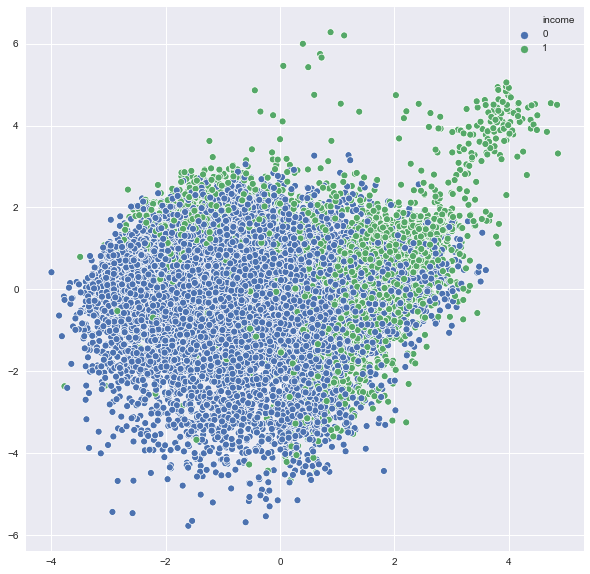

In [72]:
plt.figure(figsize=(10,10))
sns.scatterplot(X_pca[:, 0], X_pca[:, 1], hue=y);

По данному графику сразу становится понятно что при 2ух компонентах SVM не сможет хорошо разделить данные

In [65]:
X_train, X_test, y_train, y_test = train_test_split(PCA_data, pca_y, test_size = 0.2, random_state = 2020)

svc_model = SVC()
check_model(svc_model, X_train, X_test, y_train, y_test)

C:\Users\gento\Anaconda3\lib\site-packages\sklearn\svm\base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


[[4667  275]
 [ 718  853]]
              precision    recall  f1-score   support

           0       0.87      0.94      0.90      4942
           1       0.76      0.54      0.63      1571

    accuracy                           0.85      6513
   macro avg       0.81      0.74      0.77      6513
weighted avg       0.84      0.85      0.84      6513

0.14289004914004913 0.15246430216490098


Я ожидал более плохого результата, но SVM показал себя лучше KNN

In [77]:
f1_score_list = []

for i in range(2, PCA_data.shape[1]+1):
    model = SVC(gamma='auto')
    pca = PCA(n_components=i)
    new_X = pca.fit_transform(PCA_data)
    X_train, X_test, y_train, y_test = train_test_split(new_X, pca_y)
    model.fit(X_train, y_train)
    y_test_predict = model.predict(X_test)
    y_train_predict = model.predict(X_train)

    f1_score_pca_test = f1_score(y_test, y_test_predict)
    f1_score_pca_train = f1_score(y_train, y_train_predict)

    f1_score_list.append((f1_score_pca_train, f1_score_pca_test))


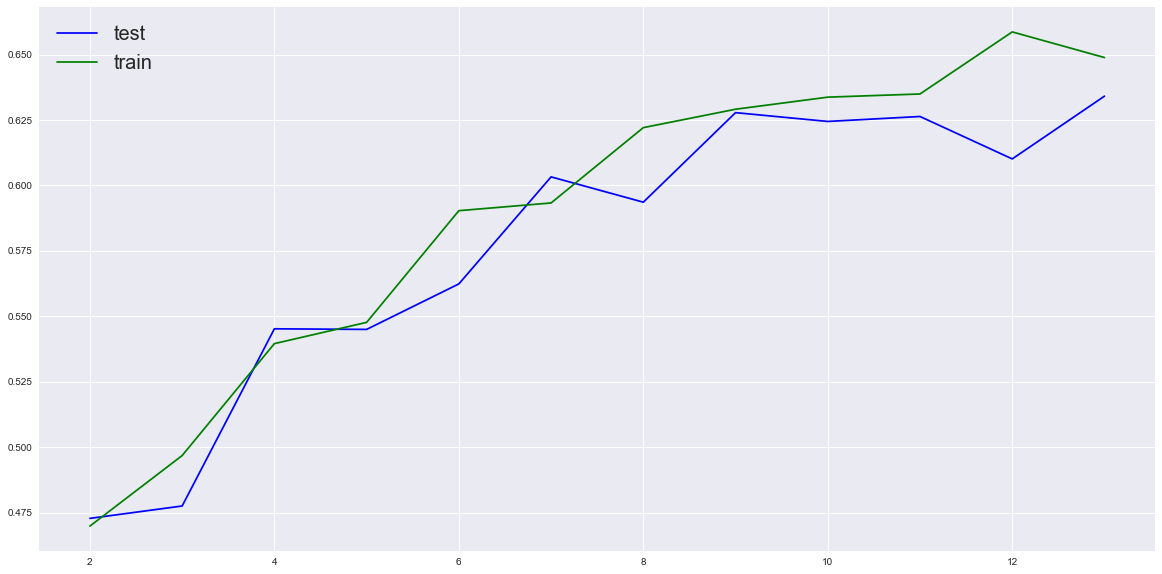

In [78]:
_, ax = plt.subplots(1, 1, figsize=(20,10))
x_ax = np.array(range(2, len(f1_score_list) + 2))
ax.plot(x_ax, np.array(f1_score_list)[:, 1], 'b')
ax.plot(x_ax, np.array(f1_score_list)[:, 0], 'g')
ax.legend(["test", "train"], fontsize=20)
pass